In [1]:
import nibabel as nb
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import ptitprince as pt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec

from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from aidhs.paths import BASE_PATH
import random


Setting DATA_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals
Setting EXPERIMENT_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/models
Setting PARAMS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/params
Setting FS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/fs_outputs
Setting HIPPUNFOLD_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/hippunfold_outputs
Setting BIDS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231211_preprocess_manuscript_submissionlAnnals/output/bids_outputs


### Load volumes

In [2]:
features_title = {
                '.hippunfold_volume_icvcorr' :'hippocampal volume\nicv-corrected (mm$^3$)',
                '.hippunfold_volume' :'hippocampal volume (mm$^3$)',
                '.FS_volume_icvcorr' :'FastSurfer hippocampal volume\nicv-corrected (mm$^3$)',
                '.FS_volume' :'FastSurfer hippocampal volume (mm$^3$)',
                
                '.total_volume' :'intracranial volume (mm$^3$)',
    }

features=[
    '.label-avg.hippunfold_volume_icvcorr',
    '.label-avg.hippunfold_volume',
    '.label-avg.FS_volume_icvcorr',
    '.label-avg.FS_volume',

]

def return_features_title(feature, features_title):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]


In [8]:
cohort = AidhsCohort(hdf5_file_root="{site_code}_{group}_featurematrix_smoothed_avg.hdf5", dataset='dataset_C-P-DC_alltrain.csv')

subjects = cohort.get_subject_ids(group='both', lesional_only = False)

hemis=['lh','rh']

In [9]:
# create dataframe with volumes
from aidhs.data_preprocessing import extract_totalbrainvolume_freesurfer


def is_nan(x):
    return (x != x)

ages = []

base_features=features


df=pd.DataFrame()
for subject in subjects:
    # create subject object
    subj = AidhsSubject(subject, cohort=cohort)
    group=subj.get_demographic_features("group")
    if group=='P':
        lesional_hemi = subj.get_demographic_features("Lesional hemi")
    elif group=='DC':
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    else:
        lesional_hemi = random.choice(['lh','rh'])   #random choice
     #initialise segmentations folders
    id_FS, folder_FS = subj.get_demographic_features(["Freesurfer_ids", "Freesurfer_folder"])
    for hemi in hemis:
        values={}
        #get demographic info 
        values['ID']=subj.subject_id
        values['group']=group
        values['hemi'] = hemi
        values['site'], values['age_scan'], values['sex'], values['mri_neg'], values['age_onset'], values['epilepsy_duration']= subj.get_demographic_features(["Site","Age at preoperative", "Sex", "Ever reported MRI negative", "Age of onset of epilepsy","Duration of Epilepsy"])
        if is_nan(lesional_hemi):
            values['lesional'] = np.nan
        elif hemi==lesional_hemi:
            values['lesional'] = 'ipsi'
        else:
            values['lesional'] = 'contra'  
        #get structural and intensity features        
        for feature in features:
            vals = subj.load_feature_values(feature, hemi)
            if vals.sum()!=0:
                values[feature]=vals[0]
            else:
                pass 
        #get total ICV
        values['.label-avg.total_volume'] = extract_totalbrainvolume_freesurfer(os.path.join(folder_FS, id_FS))
        # save values for each subject in panda matrix
        df2 = pd.DataFrame([values])
        df = pd.concat([df,df2],ignore_index=True)


FileNotFoundError: [Errno 2] No such file or directory: '/home/mathilde/Documents/projects/surHippo/processes/220830_fastsurfer_v7/sub-MELDH29P0001/stats/aparc.DKTatlas+aseg.deep.volume.stats'

In [8]:
df

,ID,group,hemi,site,age_scan,sex,mri_neg,age_onset,epilepsy_duration,lesional,.label-avg.hippunfold_volume_icvcorr,.label-avg.hippunfold_volume,.label-avg.total_volume
0,AIDHSH29P0001,P,lh,H29,43.0,0.0,0.0,17.0,26.0,ipsi,1788.203003,1788.982056,1312003
1,AIDHSH29P0001,P,rh,H29,43.0,0.0,0.0,17.0,26.0,contra,2227.896973,2229.161621,1312003
2,AIDHSH29P0002,P,lh,H29,26.0,1.0,0.0,0.8,25.2,ipsi,1624.820679,1587.072632,1012007
3,AIDHSH29P0002,P,rh,H29,26.0,1.0,0.0,0.8,25.2,contra,2699.290527,2638.010986,1012007
4,AIDHSH29P0003,P,lh,H29,20.0,0.0,0.0,13.0,7.0,ipsi,1422.919189,1427.324463,1340239
...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,H1DC0030,DC,rh,H1,14.6,0.0,0.0,NaN,NaN,ipsi,2258.496826,2212.671875,1086136
722,H1DC0031,DC,lh,H1,4.6,1.0,0.0,NaN,NaN,ipsi,1966.329834,1969.437500,1330135
723,H1DC0031,DC,rh,H1,4.6,1.0,0.0,NaN,NaN,contra,2056.470703,2061.515625,1330135
724,H1DC0032,DC,lh,H1,16.0,1.0,1.0,NaN,NaN,ipsi,1906.411255,1895.781250,1223165


In [3]:
#load or save matrix
output_path=os.path.join(BASE_PATH, 'data_saved')
file = os.path.join(output_path,'matrix_features_intracranialvolumes_230920.csv')   
# df.to_csv(file)
df=pd.read_csv(file)

#### Plot raw volumes with age & sex

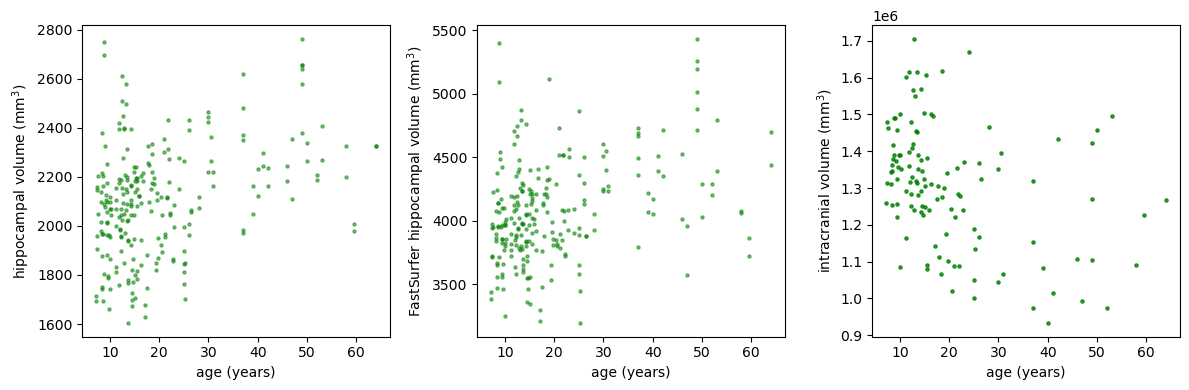

In [11]:

sexes=['male','female']
color = {'male':'blue', 'female':'pink',}
sub_features = ['.label-avg.hippunfold_volume','.label-avg.FS_volume', '.label-avg.total_volume']

fig = plt.figure(figsize=(12,4))
gs1 = gridspec.GridSpec(1, 3)
axs = []


for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))

    subdf = df.dropna(subset=[feature])

    #plot controls 
    subdf_c = subdf[subdf['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    vals_c = subdf_c[feature].copy()
    axs[i].scatter(age_c,vals_c,c='green',s=5, alpha=0.5, label='healthy controls')
    axs[i].set_ylabel(return_features_title(feature, features_title))
    axs[i].set_xlabel('age (years)')

plt.tight_layout()

#### Plot correlation features with ICV 

In [5]:
# directory to save images
OUTPUT_PATH = os.path.join(BASE_PATH,'images')

                            OLS Regression Results                            
Dep. Variable:           hippo_volume   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.645
Date:                Wed, 13 Dec 2023   Prob (F-statistic):             0.0574
Time:                        15:00:47   Log-Likelihood:                -1653.2
No. Observations:                 242   AIC:                             3310.
Df Residuals:                     240   BIC:                             3317.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1884.1797    116.132     16.224      0.0

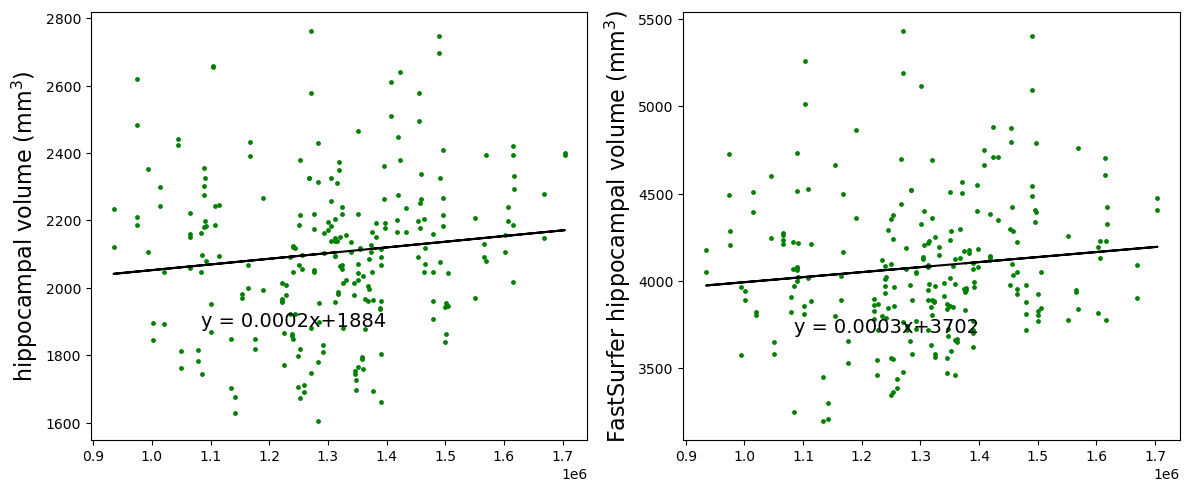

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sub_features = ['.label-avg.hippunfold_volume', '.label-avg.FS_volume']
#select controls
df_c = df[df['group']=='C']

fig = plt.figure(figsize=(12,5))
gs1 = gridspec.GridSpec(1, 2)
axs = []

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))

    data = pd.DataFrame()
    data['hippo_volume']=df_c[feature].copy()
    data['ICV']=df_c['.label-avg.total_volume'].copy()
    
    
    subdf = df_c.dropna(subset=[feature])
    axs[i].scatter(data['ICV'], data['hippo_volume'], s=6, color='green')
    axs[i].set_ylabel(return_features_title(feature, features_title), fontsize = 16)
    axs[i].set_xlabel(return_features_title('ICV', features_title), fontsize = 16)

    #fit linear regression
    res = smf.ols(f'hippo_volume ~ ICV', data=data).fit()

    print(res.summary())
    

    m = res.params['ICV']
    print(m)
    b = res.params['Intercept']
    print(b)

    mean_icv = data['ICV'].mean()
    print(mean_icv)
    
    p=res.pvalues['ICV']
    print(p.round(3))
    
    axs[i].plot(data['ICV'], m*data['ICV']+b, color='black')
    axs[i].text(1.4e6,
                b,
                'y = {:.4f}x+{:d}'.format(m,int(b)),
                ha='right', fontsize=14)
plt.tight_layout()


# fig.savefig(f'{OUTPUT_PATH}/correlation_volume_icv.png', dpi=96, transparent =True, bbox_inches = 'tight')

In [ ]:
# # with sklearn
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import f_regression

# sub_features = ['.label-avg.hippunfold_volume', '.label-avg.FS_volume']
# #select controls
# df_c = df[df['group']=='C']

# fig = plt.figure(figsize=(12,5))
# gs1 = gridspec.GridSpec(1, 2)
# axs = []

# for i,feature in enumerate(sub_features):
#     axs.append(fig.add_subplot(gs1[i]))

#     subdf = df_c.dropna(subset=[feature])
#     axs[i].scatter(subdf['.label-avg.total_volume'], subdf[feature], s=6, color='green')
#     axs[i].set_ylabel(return_features_title(feature, features_title), fontsize = 16)
#     axs[i].set_xlabel(return_features_title('.label-avg.total_volume', features_title), fontsize = 16)

#     #fit linear regression
#     reg = LinearRegression().fit(subdf[['.label-avg.total_volume']], subdf[feature])
#     m = reg.coef_[0]
#     print(m)
#     b =reg.intercept_
#     print(b)

#     mean_icv = subdf['.label-avg.total_volume'].mean()
#     print(mean_icv)
    
#     freg=f_regression(subdf[['.label-avg.total_volume']], subdf[feature])
#     p=freg[1]
#     print(p.round(3))
    
#     axs[i].plot(subdf['.label-avg.total_volume'], m*subdf['.label-avg.total_volume']+b, color='black')
#     axs[i].text(1.4e6,
#                 b,
#                 'y = {:.4f}x+{:d}'.format(m,int(b)),
#                 ha='right', fontsize=14)
# plt.tight_layout()


# # fig.savefig(f'{OUTPUT_PATH}/correlation_volume_icv.png', dpi=96, transparent =True, bbox_inches = 'tight')